In [31]:
kaggle=False
kaggle_path=''
local_path='train.csv'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchtext
import pandas as pd
import time
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [32]:

df=pd.read_csv(kaggle_path if kaggle else local_path)
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [33]:
# label encoding of keyword using sklearn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['keyword'] = le.fit_transform(df['keyword'].fillna(''))
df['keyword'].sample(5)

890      26
1678     49
6358    185
3279     95
5332    155
Name: keyword, dtype: int64

In [34]:
df['keyword'].nunique()

222

In [35]:
df.target.unique()

array([1, 0])

In [36]:
df.sample(20)

,id,keyword,location,text,target
275,401,8,NaN,RT: janenelson097: RT StephenSCIFI: Adaptation...,0
1019,1480,30,Oklahoma City,Micom 2015 Summer Contrast Candy Color Bowknot...,0
4318,6132,124,NaN,The Prophet (peace be upon him) said 'Save you...,1
2554,3662,74,"Jerseyville, IL",Dem FLATLINERS who destroy creativity-balance-...,1
6916,9918,203,"Indiana, USA",@BadAstronomer ...I have a lot of trouble gett...,0
6475,9262,189,"Gaborone, Botswana",Yup. Still hasn't sunk in. ?? https://t.co/Ii2...,0
5971,8524,174,Honeymoon Ì£ve.,@ArianaGrande @justinbieber All the loves be s...,0
5872,8389,171,CA ??DC,there are a few people I'd let ruin my life my...,0
6776,9708,199,"New Delhi, India",Rly tragedy in MP: Some live to recount horror...,1
839,1218,24,NaN,I love the cotton candy blizzard??,0


In [37]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Tokenizer-Funktion
def tokenizer(text):
    # use spacey for tokenization
    return [tok.text for tok in nlp.tokenizer(text)]

# Vokabular erstellen
def build_vocab(texts, vocab_size=None):
    word_to_idx = {}
    for text in texts:
        tokens = tokenizer(text)
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = len(word_to_idx)
    if vocab_size is not None:
        word_to_idx = {k: v for k, v in sorted(word_to_idx.items(), key=lambda item: item[1])[:vocab_size]}
    return word_to_idx

# Texte in Sequenzen von Wortindizes umwandeln
def text_to_indices(text, word_to_idx):
    tokens = tokenizer(text)
    indices = [word_to_idx[token] if token in word_to_idx else 0 for token in tokens]
    return indices

# Hyperparameter
vocab_size = None  # infinite vocab
word_count = 200
embedding_dim = 128
hidden_dim = 256
num_layers = 2
num_classes = 2
batch_size = 32

num_epochs = 2

# Aufteilung in Trainings- und Testdaten
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Erstellung des Vokabulars
texts = train_df['text'].tolist()
word_to_idx = build_vocab(texts)
vocab_size=len(word_to_idx)
print("vocab size:", vocab_size)

  0%|          | 0/6090 [00:00<?, ?it/s]

vocab size: 22879


In [38]:
def text_pipeline(x):                           
    return text_to_indices(x, word_to_idx)

text_pipeline("This is a test sentence")

[108, 17, 7, 3379, 0]

In [39]:
class DisasterTweetsDataset(Dataset):
    def __init__(self, df, vocab_size=10000, test=False):
        self.df = df
        self.vocab_size = vocab_size
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x= self.df.iloc[idx]["text"]
        keyword = self.df.iloc[idx]["keyword"]
        if not self.test:
            y= self.df.iloc[idx]["target"]
            y = int(y)
            y= torch.tensor(y, dtype=torch.long)
        x = text_pipeline(x)
        x = torch.tensor(x)
        keyword = torch.tensor(keyword, dtype=torch.long)
        if not self.test:
            return x, keyword, y
        return x, keyword
    
disaster_tweets_dataset = DisasterTweetsDataset(df, vocab_size=vocab_size)
x, keyword, y=disaster_tweets_dataset[378]
print(x)
print(keyword)
print(y)

tensor([ 330, 1448,  137,   26,  794,   18, 3216, 1109,  294,    2, 2008, 3215,
           0])
tensor(10)
tensor(0)


In [40]:
def collate_batch(batch):
    x, keyword, y = zip(*batch)
    # collate for embedding bag
    offsets = [0] + [len(x_i) for x_i in x]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    x = torch.cat(x)
    y = torch.stack(y)
    keywords=torch.stack(keyword)
    return x, offsets, keywords, y


# test custom collate function

print("Tweet 0:'", df.iloc[1].text, "' |  target", df.iloc[0].target)
print("Tweet 1:'", df.iloc[1].text, "' |  target", df.iloc[1].target)
print(collate_batch([disaster_tweets_dataset[0], disaster_tweets_dataset[1]]))





Tweet 0:' Forest fire near La Ronge Sask. Canada ' |  target 1
Tweet 1:' Forest fire near La Ronge Sask. Canada ' |  target 1
(tensor([  522, 10453,    39,     5,  3834,    10,    40,     2,   532,   968,
            0,     0,   214,    63,   315,    77,   291,  1333, 13127, 13322,
            4,  1589]), tensor([ 0, 14]), tensor([0, 0]), tensor([1, 1]))


In [41]:


from torch import nn
import torch.nn.init as init

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim,  num_class, keywords_size=30, keyword_embedding_dim=4):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)  # sparse means: 
        self.keywords_embedding = nn.Embedding(keywords_size, keyword_embedding_dim)
        self.fc1 = nn.Linear(embed_dim+keyword_embedding_dim, 30)
        self.dropout = nn.Dropout(0.5)
        self.fc2= nn.Linear(30, num_class)
        self.batchnorm = nn.BatchNorm1d(30)
        self.relu=nn.ReLU()
        self.init_weights()
        

    def init_weights(self):
        initrange = 0.5
        # uniform initialisation for the embedding layer
        self.embedding.weight.data.uniform_(-initrange, initrange)
        #self.fc.weight.data.uniform_(-initrange, initrange)
        #self.fc.bias.data.zero_()
        
        # He initialisation for the weights of the fully connected layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

    def forward(self, text, offsets, keywords):
        embedded = self.embedding(text, offsets)
        keywords_embedded = self.keywords_embedding(keywords)
        embedded = torch.cat((embedded, keywords_embedded), dim=1)
        out=self.fc1(embedded)
        out=self.batchnorm(out)
        out=self.dropout(out)
        out=self.relu(out)
        return self.fc2(out)
    
# test model
x1, keyword1, y1=disaster_tweets_dataset[378]
x2, keyword2, y2=disaster_tweets_dataset[379]
model = TextClassificationModel(vocab_size, embedding_dim, num_classes, keywords_size=df.keyword.nunique(), keyword_embedding_dim=12)
# concat x1 and x2
xb=torch.cat((x1, x2))
offsets=torch.tensor([0, len(x1)])
keywords=torch.tensor([keyword1, keyword2])
model(xb, offsets, keywords)

tensor([[-0.0433, -0.1702],
        [ 0.3332, -1.0894]], grad_fn=<AddmmBackward0>)

Initializing weights in a neural network, including an embedding layer like nn.EmbeddingBag in PyTorch, is a crucial step in preparing the model for training. The init_weights method in your TextClassificationModel class plays a significant role in this process. Here's why it's important:

* Breaking Symmetry: When a network starts with all weights having the same value, learning can be inefficient or even stall completely. Different initial weights allow for symmetry breaking, ensuring that different neurons can learn different functions.
* Improving Convergence: Proper initialization can speed up the convergence of the training process by starting the optimization closer to the optimal solution. Bad initialization can lead to slower convergence or getting stuck in suboptimal minima.
* Control of Variance: In deep networks, it's important to control the variance of activations and gradients as they pass through the layers. If the variance is too high, you might encounter exploding gradients; if it's too low, vanishing gradients can occur. Good initialization keeps the variance in a reasonable range.
* Embedding Specifics: For embedding layers, like nn.EmbeddingBag, initialization is particularly important because they map discrete input (like words) into continuous vectors. The initial values of these vectors can determine how effectively the model learns the relationships between different inputs. A uniform distribution, as used in your init_weights method, is a common choice. It assigns a wide range of different values to the embedding weights, encouraging the model to explore a diverse set of representations.
* Sparse Embeddings: You're using a sparse embedding (sparse=True), which is often used for memory efficiency with large vocabularies. Sparse embeddings can have different optimization dynamics compared to dense embeddings, and initializing them properly can be even more crucial to ensure that the sparse gradients are effective in updating the weights.
* Consistency and Reproducibility: By initializing weights in a controlled manner (like using a fixed range in your case), you can have more consistent results across different runs, which is important for debugging and comparing different models.

In [42]:
# test all together
df_to_test=df.sample(10)
dataset_to_test = DisasterTweetsDataset(df_to_test, vocab_size=vocab_size)
dataloader_to_test = DataLoader(dataset_to_test, batch_size=4, shuffle=True, collate_fn=collate_batch)
for x, offsets, keywords, y in dataloader_to_test:
    print("x: ", x)
    print("offsets: ", offsets)
    print("keywords: ", keywords)
    print("y: ", y)
    print("model output: " , model(x, offsets, keywords))
    print("End Batch\n\n\n")

x:  tensor([ 9285,  6283,    26, 16275,   103,   233,    11,  1734,     8,   623,
            7,   120,   559,   858,  9344,  8312,   107,    93,    19,  1941,
           89,    15,  2979,   592,     5,  2580,    15,   137,    32,    22,
         1899,     3,    15,  2469,    50,    21,    69,     5, 16124,    28,
          276,    21,  3359,    55, 12574,     3,   817,    73,     4, 11934,
           10,   174,    29,  1144,  4306,     4,     2, 13988,     2, 13987,
            2, 12966,     2,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3, 18626,   522,  1314,  1644, 10158,  2259,
           60,  2615,    21,    18,    62,   174,  2642,     9,     5,   734,
            4, 18020])
offsets:  tensor([ 0, 15, 46, 75])
keywords:  tensor([190,   9,  45,  45])
y:  tensor([0, 0, 0, 1])
model output:  tensor([[ 2.1358,  1.0125],
        [ 2.3355,  1.4011],
        [ 0.4730,  0.7264],
        [-0.2110,  0.4578]], grad_fn=<AddmmBackward0>)
End Batch



x:  

In [43]:
class Learner():
    
    def __init__(self, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_func):
        self.model=model
        self.train_dataloader=train_dataloader
        self.valid_dataloader=valid_dataloader
        self.optimizer=optimizer
        self.scheduler=scheduler
        self.loss_func=loss_func
        self.accu_train=[]
        self.accu_valid=[]

    def evaluate(self, loader):
        model.eval()
        total_acc, total_count = 0, 0
        with torch.no_grad():
            for idx, (x, offsets, keywords, y) in enumerate(loader):
                predicted_label = model(x, offsets, keywords)
                total_acc += (predicted_label.argmax(1) == y).sum().item()
                total_count += y.size(0)
        return total_acc/total_count


    def fit_one_epoch(self):
        epoch_start_time = time.time()
        self.model.train()

        for idx, (x, offsets, keywords, y) in enumerate(self.train_dataloader):
            self.optimizer.zero_grad()
            predicted_label = model(x, offsets, keywords)
            loss = self.loss_func(predicted_label, y)
            loss.backward()
            self.optimizer.step()

        accu_train = self.evaluate(self.train_dataloader)
        accu_valid = self.evaluate(self.valid_dataloader)
        self.accu_train.append(accu_train)
        self.accu_valid.append(accu_valid)
        self.scheduler.step() 
        return (time.time() - epoch_start_time)

    def fit_epochs(self, number=None):
        for epoch in range(number):
            epoch_time=self.fit_one_epoch()
            print('-' * 59)
            print('| end of epoch {:3d} | time: {:5.2f}s | train accuracy {:8.3f} | valid accuracy {:8.3f} | lr: {:1.2f}'.format(
                                        epoch,
                                        epoch_time,
                                        self.accu_train[-1],
                                        self.accu_valid[-1],
                                        self.scheduler.get_last_lr()[0]))    

    def plot_training(self):
        plt.plot(self.accu_train, label="train accuracy")
        plt.plot(self.accu_valid, label="valid accuracy")
        plt.legend()
        plt.show()

In [44]:
# Hyperparameters
LR = 1  # learning rate
BATCH_SIZE = 64 # batch size for training
embedding_dim = 128
num_classes = 2


model = TextClassificationModel(vocab_size, embedding_dim, num_classes, keyword_embedding_dim=12, keywords_size=df.keyword.nunique())

train_dataset=DisasterTweetsDataset(train_df, vocab_size=vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataset=DisasterTweetsDataset(test_df, vocab_size=vocab_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

loss_func = torch.nn.CrossEntropyLoss()
#
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3.0, gamma=0.9)   # every 3 epochs, LR is multiplied by 0.7

learner=Learner(model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_func)

-----------------------------------------------------------
| end of epoch   0 | time:  1.62s | train accuracy    0.621 | valid accuracy    0.617 | lr: 1.00
-----------------------------------------------------------
| end of epoch   1 | time:  1.51s | train accuracy    0.664 | valid accuracy    0.619 | lr: 1.00
-----------------------------------------------------------
| end of epoch   2 | time:  1.52s | train accuracy    0.635 | valid accuracy    0.599 | lr: 0.90
-----------------------------------------------------------
| end of epoch   3 | time:  1.52s | train accuracy    0.695 | valid accuracy    0.644 | lr: 0.90
-----------------------------------------------------------
| end of epoch   4 | time:  1.52s | train accuracy    0.726 | valid accuracy    0.672 | lr: 0.90
-----------------------------------------------------------
| end of epoch   5 | time:  1.51s | train accuracy    0.651 | valid accuracy    0.596 | lr: 0.81
----------------------------------------------------------

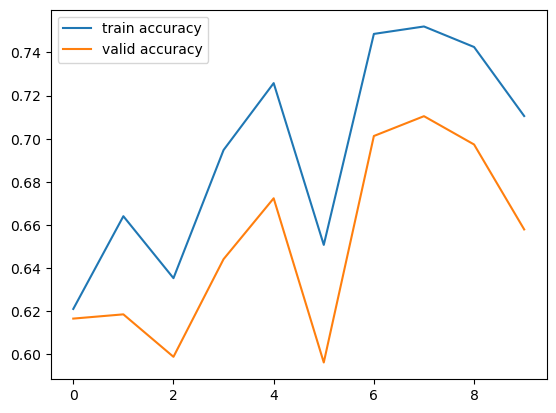

In [45]:

learner.fit_epochs(2)
learner.plot_training()

-----------------------------------------------------------
| end of epoch   0 | time:  1.62s | train accuracy    0.756 | valid accuracy    0.724 | lr: 0.73
-----------------------------------------------------------
| end of epoch   1 | time:  1.52s | train accuracy    0.663 | valid accuracy    0.603 | lr: 0.66
-----------------------------------------------------------
| end of epoch   2 | time:  1.51s | train accuracy    0.777 | valid accuracy    0.735 | lr: 0.66
-----------------------------------------------------------
| end of epoch   3 | time:  1.52s | train accuracy    0.772 | valid accuracy    0.737 | lr: 0.66
-----------------------------------------------------------
| end of epoch   4 | time:  1.51s | train accuracy    0.775 | valid accuracy    0.724 | lr: 0.59
-----------------------------------------------------------
| end of epoch   5 | time:  1.55s | train accuracy    0.779 | valid accuracy    0.746 | lr: 0.59
----------------------------------------------------------

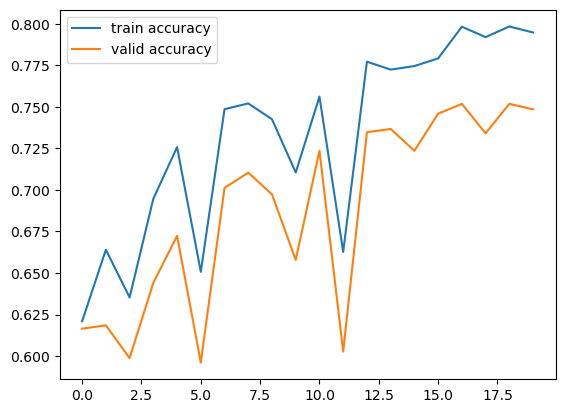

In [46]:
learner.fit_epochs(10)
learner.plot_training()

-----------------------------------------------------------
| end of epoch   0 | time:  1.59s | train accuracy    0.802 | valid accuracy    0.754 | lr: 0.48
-----------------------------------------------------------
| end of epoch   1 | time:  1.57s | train accuracy    0.810 | valid accuracy    0.749 | lr: 0.48
-----------------------------------------------------------
| end of epoch   2 | time:  1.53s | train accuracy    0.816 | valid accuracy    0.750 | lr: 0.48
-----------------------------------------------------------
| end of epoch   3 | time:  1.53s | train accuracy    0.823 | valid accuracy    0.764 | lr: 0.43
-----------------------------------------------------------
| end of epoch   4 | time:  1.56s | train accuracy    0.816 | valid accuracy    0.763 | lr: 0.43
-----------------------------------------------------------
| end of epoch   5 | time:  1.53s | train accuracy    0.822 | valid accuracy    0.768 | lr: 0.43
----------------------------------------------------------

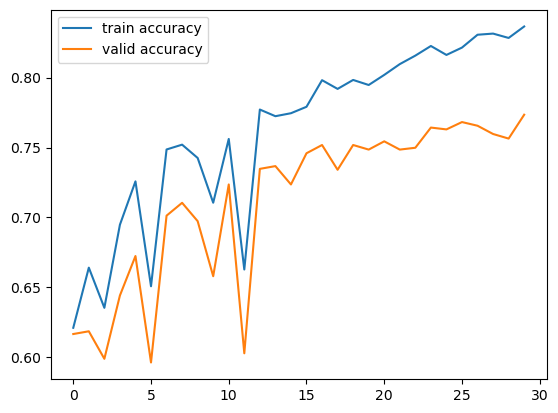

In [50]:
learner.fit_epochs(10)
learner.plot_training()

In [51]:
local_test_path='test.csv'
kaggle_test_path=''

df_submission_test_data=pd.read_csv(kaggle_test_path if kaggle else local_test_path)
df_submission_test_data.sample(5)




,id,keyword,location,text
1362,4484,electrocuted,mullingar ireland,@hairdryer180 you'll get electrocuted
1322,4364,earthquake,"Do Not Follow Me, Am I a Bot.",#Earthquake of M 2.9 - 140km W of Ferndale Cal...
2262,7538,oil%20spill,Australia,NSW - BANKSTOWN Stacey St at Wattle St\nHAZARD...
627,2044,casualties,NaN,@JimW_in_NM @KurtSchlichter Here's the thing: ...
3152,10463,wild%20fires,Colorado,Stampedes and fires brought him home; can her ...


In [55]:
# label encode keyword using trained label encoder
df_submission_test_data['keyword'] = le.transform(df_submission_test_data['keyword'].fillna(''))

In [69]:
def collate_batch_test_data(batch):
    x, keywords = zip(*batch)
    # collate for embedding bag
    offsets = [0] + [len(x_i) for x_i in x]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    x = torch.cat(x)
    keywords=torch.stack(keywords)
    return x, offsets, keywords

In [71]:
model.eval()
preds=[]
test_dataset=DisasterTweetsDataset(df_submission_test_data, vocab_size=vocab_size, test=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_test_data)
with torch.no_grad():
    for idx, (x, offsets, keywords) in enumerate(test_dataloader):
        predicted_label = model(x, offsets, keywords)
        preds.extend(predicted_label.argmax(1).tolist())

df_submission_test_data["target"]=preds
df_submission_test_data[["id", "target"]].to_csv("submission.csv", index=False)

In [ ]:
# Score: 0.75237